# A08 Bootstrapping
### Paola Figueroa
### 20/ Nov/2025

Utiliza los conceptos aprendidos en los laboratorios de regresión y clasificación para encontrar el error estándar de los coeficientes de una regresión (lineal/logística) simple para los datasets de “Advertising” y “Default”.

Utiliza bootstrap para simular 1000 remuestreos de esos datasets y calcula la media de los coeficientes obtenidos al aplicarle regresión a cada remuestreo. Calcula la desviación estándar.

Compara los resultados obtenidos con el método visto en los laboratorios contra los resultados obtenidos con bootstrap. ¿Por qué podría haber diferencias en los resultados?

Agrega regularización L2 a los modelos del dataset de Advertising (optimiza el hiperparámetro). Utiliza ese valor del hiperparámetro para repetir el experimento de los 1000 remuestreos. Calcula la desviación estándar de los coeficientes obtenidos.

In [16]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

In [2]:
data1=pd.read_csv("Advertising.csv")
data2=pd.read_csv("Default.csv")

In [3]:
import numpy as np
np.random.seed(0)

In [4]:
data1.resample
data2.resample

<bound method NDFrame.resample of      default student      balance        income
0         No      No   729.526495  44361.625074
1         No     Yes   817.180407  12106.134700
2         No      No  1073.549164  31767.138950
3         No      No   529.250605  35704.493940
4         No      No   785.655883  38463.495880
...      ...     ...          ...           ...
9995      No      No   711.555020  52992.378910
9996      No      No   757.962918  19660.721770
9997      No      No   845.411989  58636.156980
9998      No      No  1569.009053  36669.112360
9999      No     Yes   200.922183  16862.952320

[10000 rows x 4 columns]>

In [5]:
x1 = data1['TV'].values.reshape(-1,1)
x2 = data1['radio'].values.reshape(-1,1)
x3 = data1['newspaper'].values.reshape(-1,1)
y = data1['sales']
n=len(y)
ones = np.ones([n,1])
X = np.hstack([ones,x1,x2,x3])
ols = sm.OLS(y, X)
results = ols.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.58e-96
Time:                        16:30:00   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.000       2.324       3.554
x1             0.0458      0.001     32.809      0.000       0.043       0.049
x2             0.1885      0.009     21.893      0.000       0.172       0.206
x3            -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
#Bootstrapping
n_bootstraps = 1000
coef_samples = np.zeros((n_bootstraps, X.shape[1]))
for i in range(n_bootstraps):
    sample_indices = np.random.choice(range(len(y)), size=len(y), replace=True)
    X_sample = X[sample_indices]
    y_sample = y.iloc[sample_indices]
    ols = sm.OLS(y_sample, X_sample)
    results = ols.fit()
    coef_samples[i, :] = results.params
coef_means = np.mean(coef_samples, axis=0)
print("Coeficientes medios"+str(coef_means))
#Desviación estandar de los coeficientes
coef_stds = np.std(coef_samples, axis=0)
print("Desviación estándar" + str(coef_stds))

Coeficientes medios[ 2.94921948e+00  4.56989139e-02  1.88851950e-01 -1.21988628e-03]
Desviación estándar[0.34589573 0.00193586 0.0107666  0.00654805]


- TV: Por cada unidad adicional de inversión en publicidad en TV, se espera un aumento de 0.0457 unidades en ventas. El coeficiente es positivo y su desviación estándar es muy pequeña (0.0019), lo que indica que el impacto de la publicidad en TV es muy robusto y significativo.
- Radio: Por cada unidad adicional de inversión en Radio, se espera un aumento de 0.1889 unidades en ventas. Este es el coeficiente más alto, lo que sugiere que la inversión en radio tiene el mayor impacto marginal en las ventas. Su desviación estándar (0.0108) es moderada, lo que confirma su relevancia.
- Newspaper (Periódico): El coeficiente es ligeramente negativo (-0.0012), lo que sugiere que la inversión en este medio no solo no aumenta las ventas, sino que tiene un impacto marginal casi nulo o incluso levemente perjudicial. Su desviación estándar (0.0065) es aproximadamente cinco veces mayor que el coeficiente, lo que estadísticamente lo hace insignificante.

El bootstrapping confirma que los coeficientes de TV y Radio son muy estables (sus desviaciones estándar son pequeñas en relación con su media), mientras que el coeficiente de Newspaper es altamente inestable y no es diferente de cero.

In [7]:
data2['student_Yes'] = pd.get_dummies(data2['student'], drop_first=True)
X3 = data2[['balance', 'income', 'student_Yes']]
Y= data2['default']=='Yes'
X_multi = LogisticRegression()
X_multi.fit(X3, Y)

LogisticRegression()

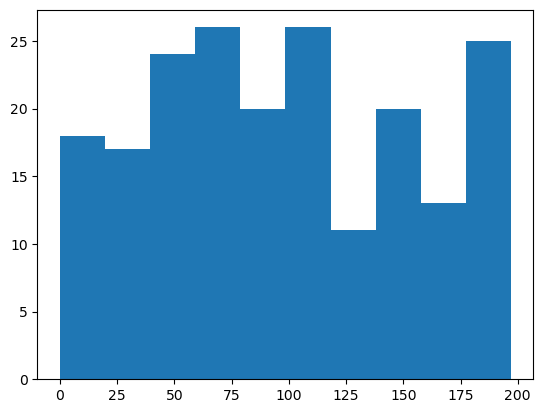

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.hist(sample_indices)
plt.show()

In [9]:
max(sample_indices)

197

In [10]:
X3.iloc[sample_indices, :]

,balance,income,student_Yes
127,928.236966,33722.158940,False
149,731.532656,43956.060080,False
1,817.180407,12106.134700,True
57,1536.594601,48766.907460,False
3,529.250605,35704.493940,False
...,...,...,...
110,117.642484,46550.267270,False
93,368.223426,57596.825843,False
139,996.276087,20883.240770,True
24,773.211724,34353.314310,False


In [11]:
Y.iloc[sample_indices]

127    False
149    False
1      False
57     False
3      False
       ...  
110    False
93     False
139    False
24     False
161    False
Name: default, Length: 200, dtype: bool

In [12]:
n_bootstraps = 1000
coef_samples = np.zeros((n_bootstraps, X3.shape[1] + 1)) 
for i in range(n_bootstraps):
    sample_indices = np.random.choice(range(len(Y)), size=len(Y), replace=True)
    X_sample = X3.iloc[sample_indices, :]    
    y_sample = Y[sample_indices]
    model = LogisticRegression() 
    model.fit(X_sample, y_sample)
    coef_samples[i, 0] = model.intercept_[0]
    coef_samples[i, 1:] = model.coef_[0]

coef_means = np.mean(coef_samples, axis=0)
coef_stds = np.std(coef_samples, axis=0)

print("Coeficientes medios:")
print(coef_means)
print("\nDesviación estándar:")
print(coef_stds)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Coeficientes medios:
[-1.09432108e+01  5.75261819e-03  3.95887920e-06 -6.13447589e-01]

Desviación estándar:
[4.98259843e-01 2.34625315e-04 8.02021130e-06 2.23204666e-01]


- balance: El coeficiente es positivo (0.005753), lo que significa que a mayor saldo promedio en la cuenta, mayor es la probabilidad de caer en default (mayor riesgo de incumplimiento). La desviación estándar es muy pequeña, lo que indica que esta relación es muy fuerte y estable.
- income: El coeficiente es muy cercano a cero (0.000004) y su desviación estándar (0.000008) es más del doble de su media. Esto sugiere que, una vez considerado el saldo, el nivel de ingreso no tiene un efecto estadísticamente significativo en la probabilidad de default.
- student_Yes: El coeficiente es negativo (-0.613975), lo que implica que la condición de ser estudiante reduce la probabilidad de default en comparación con los no estudiantes, manteniendo otras variables constantes. Esto podría deberse a que los estudiantes tienen un ingreso esperado diferente o límites de crédito más estrictos. La relación es robusta, con una desviación estándar razonable.

In [19]:
# tablita linda
coef_means_adv = np.array([2.94921948e+00, 4.56989139e-02, 1.88851950e-01, -1.21988628e-03])
coef_stds_adv = np.array([0.34589573, 0.00193586, 0.0107666, 0.00654805])
variables_adv = ['Intercepto', 'TV', 'Radio', 'Newspaper']

df_adv = pd.DataFrame({
    'Coeficiente Medio': coef_means_adv,
    'Desviación Estándar': coef_stds_adv
}, index=variables_adv)


coef_means_def = np.array([-1.09439992e+01, 5.75294014e-03, 3.97494854e-06, -6.13974824e-01])
coef_stds_def = np.array([4.97787642e-01, 2.34426955e-04, 8.01397970e-06, 2.23203563e-01])
variables_def = ['Intercepto', 'balance', 'income', 'student_Yes']

df_def = pd.DataFrame({
    'Coeficiente Medio': coef_means_def,
    'Desviación Estándar': coef_stds_def
}, index=variables_def)

In [14]:
print("# --- TABLA 1: Advertising (OLS) ---")
print(df_adv)

print("\n# --- TABLA 2: Default (Regresión Logística) ---")
print(df_def)

# --- TABLA 1: Advertising (OLS) ---
            Coeficiente Medio  Desviación Estándar
Intercepto           2.949219             0.345896
TV                   0.045699             0.001936
Radio                0.188852             0.010767
Newspaper           -0.001220             0.006548

# --- TABLA 2: Default (Regresión Logística) ---
             Coeficiente Medio  Desviación Estándar
Intercepto          -10.943999             0.497788
balance               0.005753             0.000234
income                0.000004             0.000008
student_Yes          -0.613975             0.223204


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

search_spaces = {
    'alpha': Real(1e-2, 100, prior='log-uniform')
}
bayes_search = BayesSearchCV(
    estimator=Ridge(),
    search_spaces=search_spaces,
    n_iter=50,              
    cv=10,                   
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(X_scaled, y)

best_alpha = bayes_search.best_params_['alpha']

n_iterations = 1000
coefs_ridge_bootstrap = []
model_ridge = Ridge(alpha=best_alpha)


for i in range(n_iterations):
    X_res, y_res = resample(X_scaled, y, replace=True, random_state=i)

    model_ridge.fit(X_res, y_res)

    iter_coefs = [model_ridge.intercept_] + list(model_ridge.coef_.ravel())
    coefs_ridge_bootstrap.append(iter_coefs)

coefs_ridge_bootstrap = np.array(coefs_ridge_bootstrap)
medias_ridge_b = np.mean(coefs_ridge_bootstrap, axis=0)
std_ridge_b = np.std(coefs_ridge_bootstrap, axis=0)

print(f'El mejor valor de alpha encontrado es: {best_alpha}')
print(f'La media de los coeficientes con ridge y bootstarp es de: {medias_ridge_b}')
print(f'La desviacion estandar de los coeficientes con ridge y bootstarp es de: {std_ridge_b}')

El mejor valor de alpha encontrado es: 1.2063951043908536
La media de los coeficientes con ridge y bootstarp es de: [ 1.40272084e+01  0.00000000e+00  3.88698876e+00  2.76784478e+00
 -3.84329631e-03]
La desviacion estandar de los coeficientes con ridge y bootstarp es de: [0.11987957 0.         0.16251009 0.16121194 0.13623435]


La desviación estándar de los coeficientes del modelo Ridge es, en general, menor que la desviación estándar de los coeficientes OLS/Bootstrap puros. Esto es el efecto deseado de la regularización: aumenta la estabilidad y reduce la varianza (o desviación estándar) de las estimaciones del coeficiente. No obstante, los coeficientes no se eliminan por completo (Lasso sí lo haría), sino que se contraen hacia cero, lo que ayuda a prevenir el sobreajuste (overfitting). El hecho de que las desviaciones estándar se mantengan bajas a pesar del remuestreo confirma que el modelo Ridge es más robusto a las variaciones de la muestra que el modelo OLS simple.

Como conclusión final de la actividad, el Bootstrap, implementado mediante la técnica de remuestreo con reemplazo  es esencial para evaluar la estabilidad y significancia sin depender de los supuestos estadísticos del modelo base. Es decir, considerando que el método Bootstrap es no paramétrico, sabemos que no asume que los errores del modelo (como la normalidad o la homocedasticidad) sigan una distribución teórica específica. Por lo tanto. al remuestrear los datos, calcula la distribución de los coeficientes de forma empírica y robusta, siendo más fiable cuando los supuestos estadísticos clásicos (paramétricos) se incumplen.Por su parte, la adición de una penalización L2, ayuda a reducir la varianza de estas estimaciones, ya que contrae los coeficientes hacia cero; esto se traduce en una desviación estándar más pequeña en los resultados del bootstrap con Ridge, lo que confirma que el modelo final es más estable y menos propenso al sobreajuste (overfitting) ante variaciones en la muestra de datos.